In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm

In [2]:
train_df = pd.read_csv('train.csv')

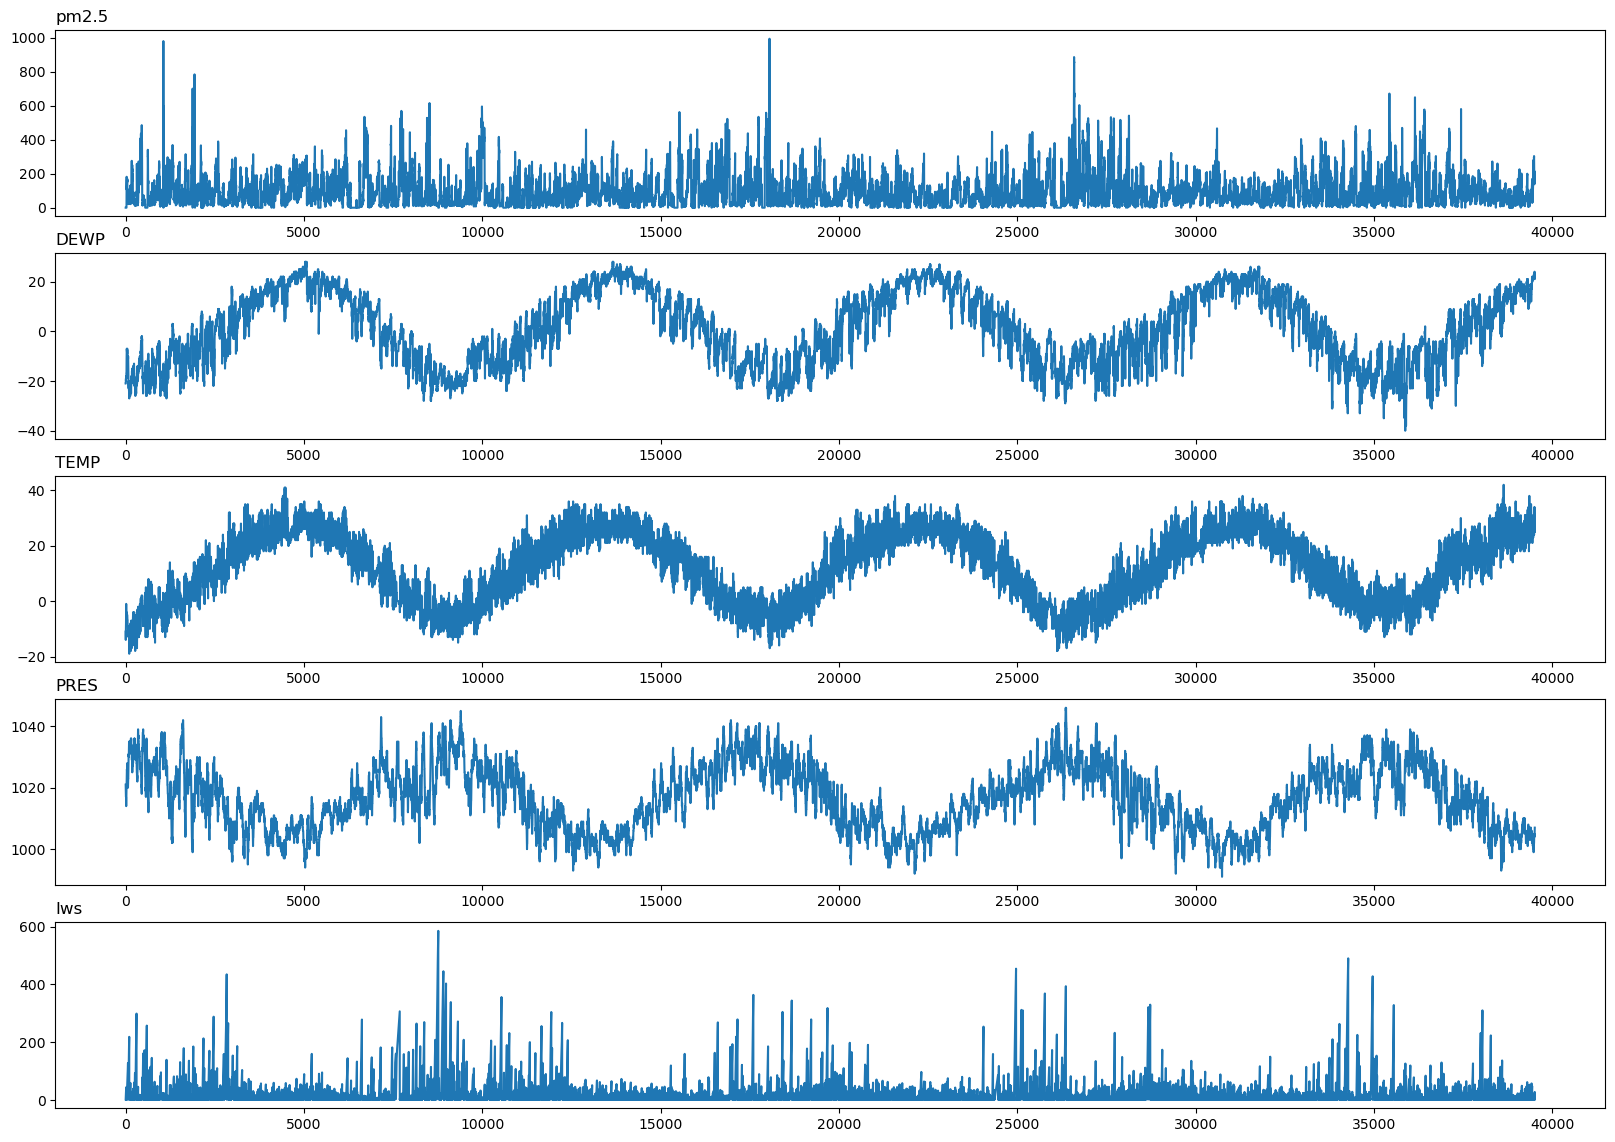

In [3]:
groups = [5, 6, 7, 8, 10]
plt.figure(figsize=(20,14))
for i in range(len(groups)):
    plt.subplot(len(groups), 1, i+1)
    plt.plot(train_df.values[:, groups[i]])
    plt.title(train_df.columns[groups[i]], loc='left')
plt.show()

In [4]:
def data_preprocessing(df):
    label_encoder = LabelEncoder()
    df['cbwd'] = label_encoder.fit_transform(df['cbwd'])
    df = df[df['pm2.5'] != -1]
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df.set_index('datetime', inplace=True)
    df.drop(['No', 'year', 'month', 'day', 'hour'], axis=1, inplace=True)
    return df

In [5]:
train_df = data_preprocessing(train_df)

scaler =  MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)

In [6]:
def series(data, columns):
    df = pd.DataFrame(data)
    
    cols, names = [], []
    cols.extend([df.shift(1)])
    names.extend([f'{columns[j]}(t-1)' for j in range(data.shape[1])])
    cols.extend([df.shift(0)])
    names.extend([f'{columns[j]}(t)' for j in range(data.shape[1])])
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    agg.dropna(inplace=True)
    agg.drop(agg.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
    
    return agg

In [7]:
reframed_train = series(scaled_train, train_df.columns)

In [8]:
def test(model):
    test_df = pd.read_csv('test.csv')
    test_df = data_preprocessing(test_df)
    scaler = MinMaxScaler()
    scaled_test = scaler.fit_transform(test_df)
    reframed_test = series(scaled_test, test_df.columns)

    values_test = reframed_test.values
    test_x, test_y = values_test[:, :-1], values_test[:, -1]

    val_pred = model.predict(test_x)
    
    poll = np.array(test_df["pm2.5"])
    poll_mean = poll.mean()
    poll_std = poll.std()

    test_y = test_y * poll_std + poll_mean
    val_pred = val_pred * poll_std + poll_mean

    rmse = mean_squared_error(test_y, val_pred, squared=False)
    print("Test RMSE =", rmse)
    mae = mean_absolute_error(test_y, val_pred)   
    print("Test MAE =", mae)
    
    plt.figure(figsize=(18, 5))
    plt.ylabel("ppm")
    plt.xlabel("hours")
    plt.plot(test_y)
    plt.plot(val_pred)
    plt.title("Testing Data Prediction")
    plt.legend(['Predicted', 'True'])
    plt.show()

Test RMSE = 4.142347633269748
Test MAE = 2.253714232903603


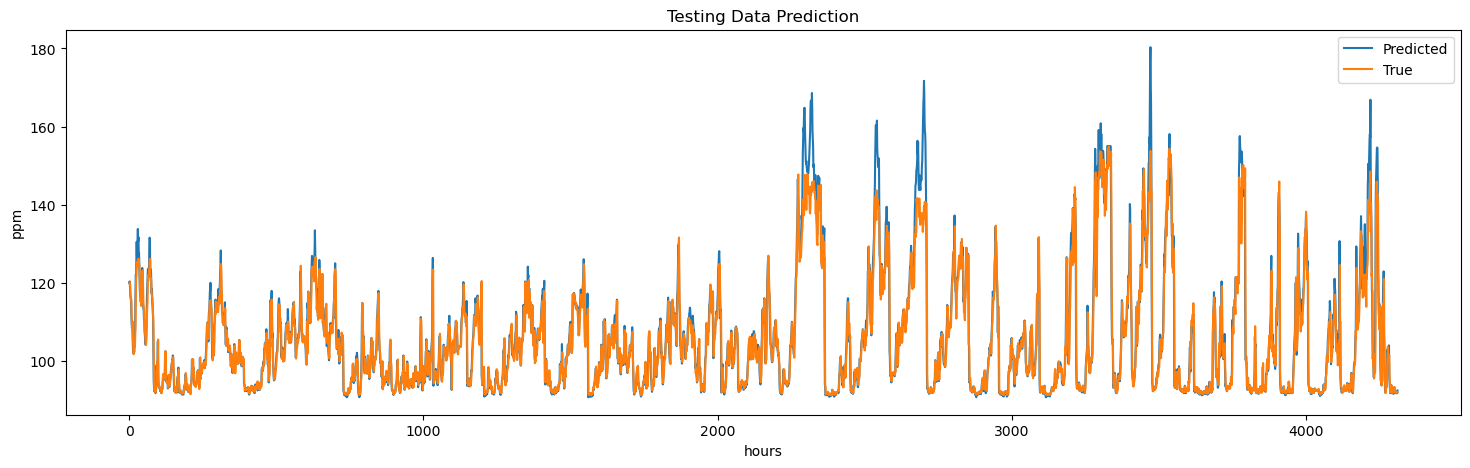

In [9]:
def use_LGBMRegressor(reframed_train):
    values = reframed_train.values
    X_train, y_train = values[:, :-1], values[:, -1]
    model = lightgbm.sklearn.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    test(model)

use_LGBMRegressor(reframed_train)

Test RMSE = 4.408282812208324
Test MAE = 2.34260460974652


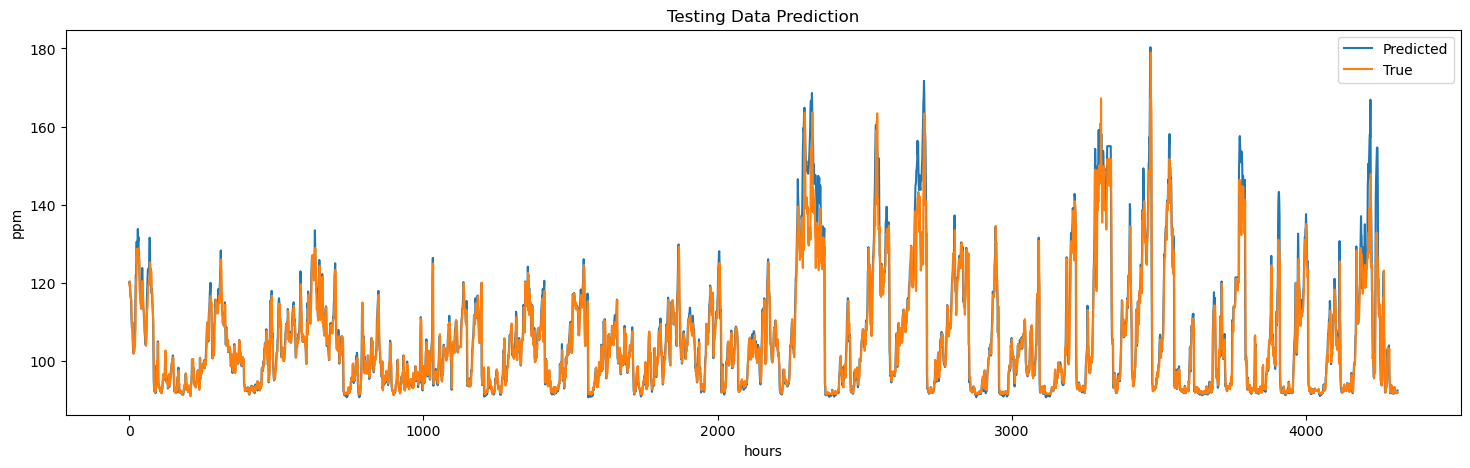

In [10]:
def use_GradientBoostingRegressor(reframed_train):
    values = reframed_train.values
    X_train, y_train = values[:, :-1], values[:, -1]

    model = GradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)

    test(model)

use_GradientBoostingRegressor(reframed_train)

Test RMSE = 5.3501723481115935
Test MAE = 2.694666329689778


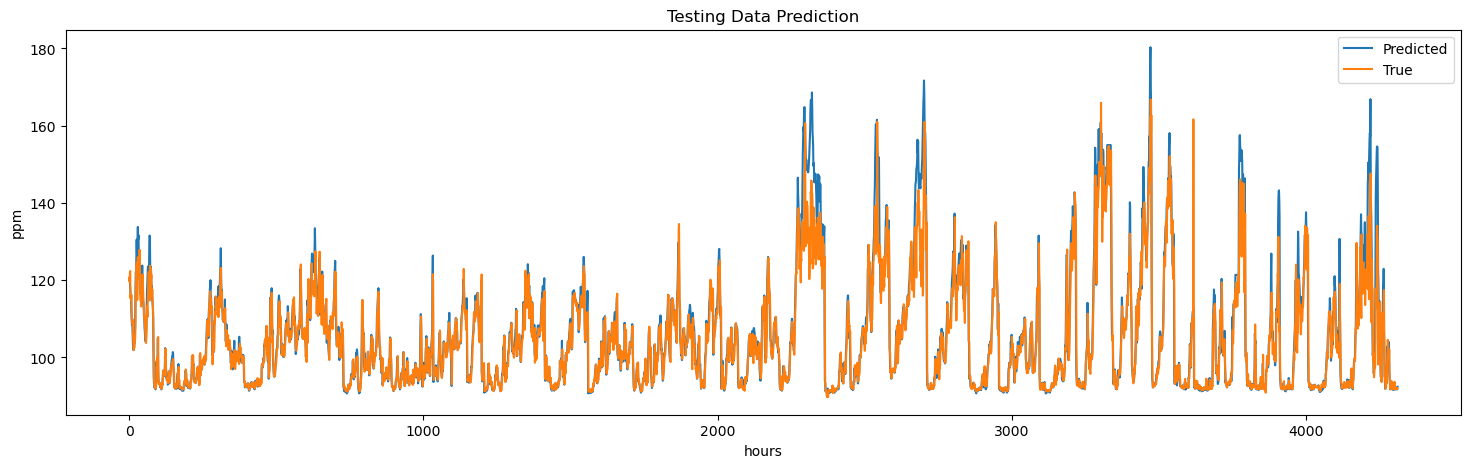

In [11]:
def use_XGBoost(reframed_train):
    values = reframed_train.values
    X_train, y_train = values[:, :-1], values[:, -1]

    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    test(model)

use_XGBoost(reframed_train)

## LSTM

In [12]:
values = reframed_train.values
X_train, y_train = values[:, :-1], values[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

In [13]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(16))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2,
                    verbose=2, shuffle=True, callbacks=[early_stopping])

Epoch 1/50
118/118 - 6s - loss: 0.1015 - val_loss: 0.0069 - 6s/epoch - 47ms/step
Epoch 2/50
118/118 - 2s - loss: 0.0098 - val_loss: 0.0055 - 2s/epoch - 16ms/step
Epoch 3/50
118/118 - 2s - loss: 0.0028 - val_loss: 0.0034 - 2s/epoch - 16ms/step
Epoch 4/50
118/118 - 2s - loss: 0.0016 - val_loss: 0.0016 - 2s/epoch - 16ms/step
Epoch 5/50
118/118 - 2s - loss: 0.0013 - val_loss: 7.1745e-04 - 2s/epoch - 16ms/step
Epoch 6/50
118/118 - 2s - loss: 0.0012 - val_loss: 9.2550e-04 - 2s/epoch - 15ms/step
Epoch 7/50
118/118 - 2s - loss: 0.0012 - val_loss: 6.1091e-04 - 2s/epoch - 16ms/step
Epoch 8/50
118/118 - 2s - loss: 0.0012 - val_loss: 5.9447e-04 - 2s/epoch - 16ms/step
Epoch 9/50
118/118 - 2s - loss: 0.0012 - val_loss: 0.0011 - 2s/epoch - 15ms/step
Epoch 10/50
118/118 - 2s - loss: 0.0011 - val_loss: 5.9535e-04 - 2s/epoch - 16ms/step
Epoch 11/50
118/118 - 2s - loss: 0.0011 - val_loss: 5.5801e-04 - 2s/epoch - 15ms/step
Epoch 12/50
118/118 - 2s - loss: 0.0011 - val_loss: 0.0011 - 2s/epoch - 16ms/step
E

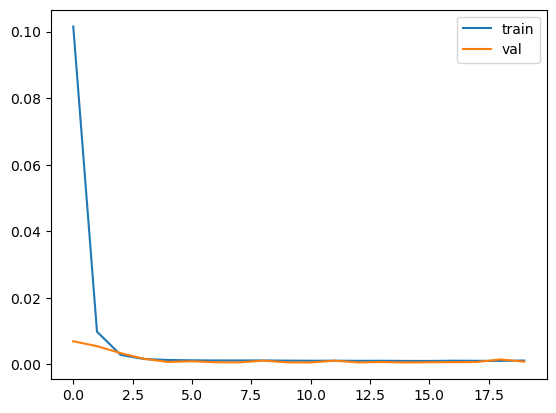

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

## Test

In [16]:
test_df = pd.read_csv('test.csv')
test_df = data_preprocessing(test_df)

scaler1 = MinMaxScaler()
scaled_test = scaler1.fit_transform(test_df)

reframed_test = series(scaled_test, test_df.columns)

values_test1 = reframed_test.values
test_x, test_y = values_test1[:, :-1], values_test1[:, -1]
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_pred = model.predict(test_x).ravel()

poll = np.array(test_df["pm2.5"])
poll_mean = poll.mean()
poll_std = poll.std()

test_y = test_y*poll_std + poll_mean
val_pred = val_pred*poll_std + poll_mean

rmse = mean_squared_error(test_y, val_pred, squared=False)
print("Test RMSE =", rmse)
mae = mean_absolute_error(test_y, val_pred)   
print("Test MAE =", mae)

135/135 [==============================] - 1s 3ms/step
Test RMSE = 3.2433976748397386
Test MAE = 1.9342810106034234


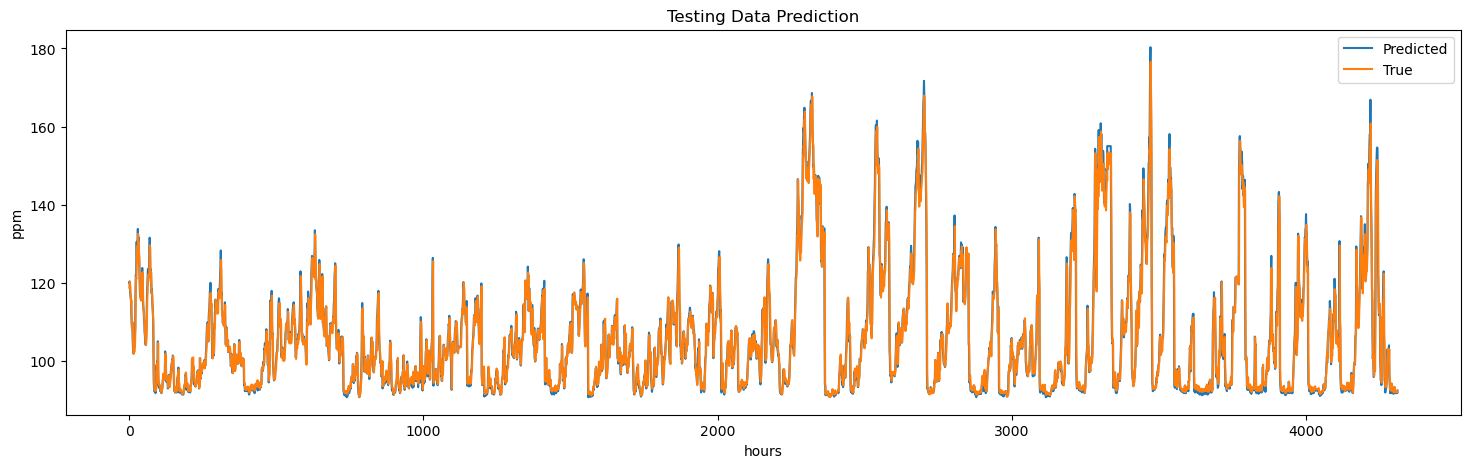

In [17]:
plt.figure(figsize=(18,5))
plt.ylabel("ppm")
plt.xlabel("hours")
plt.plot(test_y)
plt.plot(val_pred)
plt.title("Testing Data Prediction")
plt.legend(['Predicted', 'True'])
plt.show()